In [2]:
import sys
import sklearn
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## 퍼셉트론

In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])


<ipython-input-3-b100384429b1>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris.target == 0).astype(np.int)


In [4]:
y_pred

array([1])

## 활성화 함수

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z- eps)) / (2 * eps)

그림 저장: activation_functions_plot


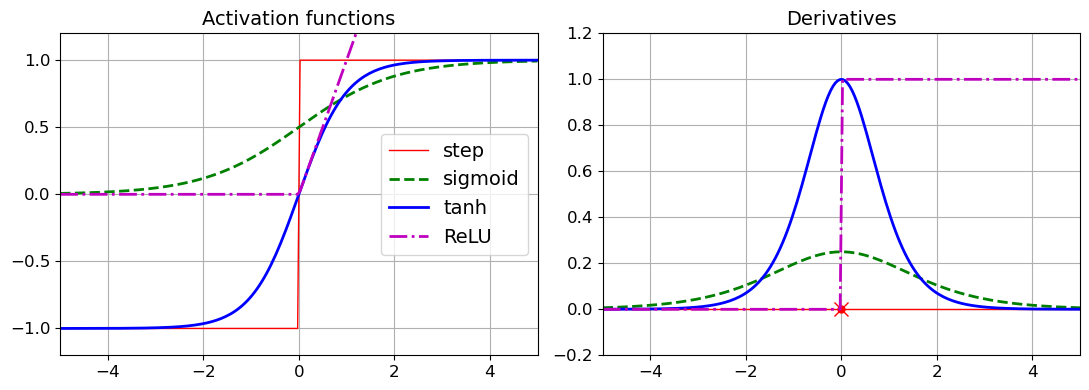

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(z, np.sign(z), 'r-', linewidth=1, label='step')
plt.plot(z, sigmoid(z), 'g--', linewidth=2, label='sigmoid')
plt.plot(z, np.tanh(z), 'b-', linewidth=2, label="tanh")
plt.plot(z, relu(z), 'm-.', linewidth=2, label='ReLU')
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z),  "r-", linewidth=1, label="step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), 'g--', linewidth=2, label="sigmoid")
plt.plot(z, derivative(np.tanh, z), 'b-', linewidth=2, label="tanh")
plt.plot(z, derivative(relu, z), 'm-.', linewidth=2, label="ReLU")
plt.grid(True)

plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## 이미지 분류기 만들기

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [9]:
X_train_full.shape # 28 x 28 픽셀 

(60000, 28, 28)

In [10]:
X_train_full.dtype 

dtype('uint8')

In [11]:
# 각 픽셀의 강도는 바이트 (0 ~ 255)로 표현
# 픽셀 강도를 255로 나누어 0~1 범위의 실수로 바꿈
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

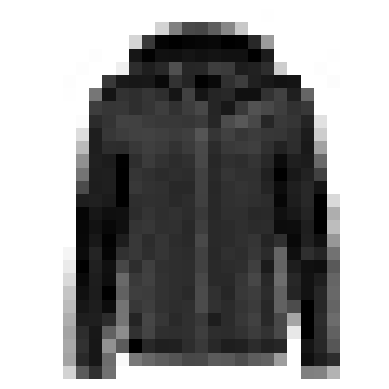

In [12]:
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()

In [13]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

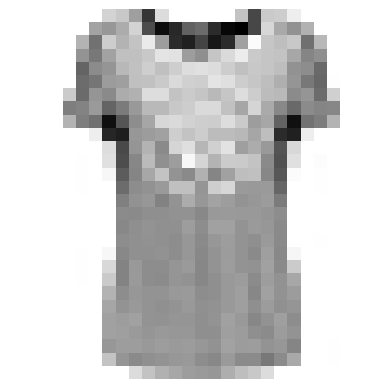

In [14]:
plt.imshow(X_train[1], cmap='binary')
plt.axis('off')
plt.show()

In [15]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [16]:
class_names[y_train[0]]

'Coat'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
그림 저장: fashion_mnist_plot


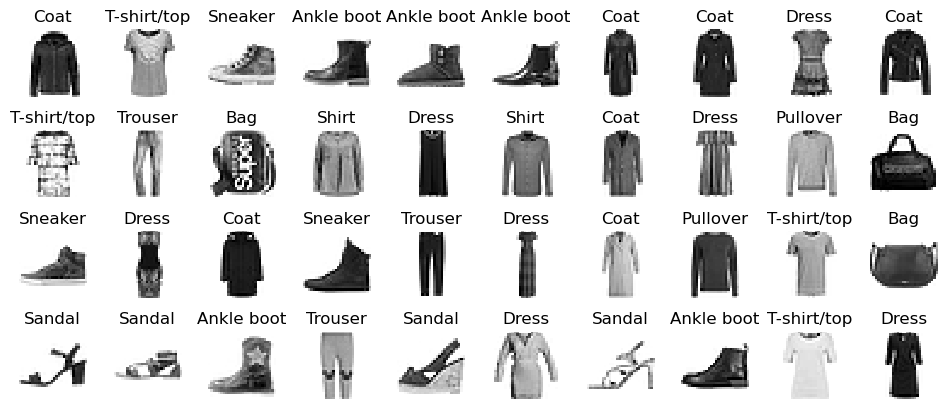

In [17]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        print(index)
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap='binary', interpolation="nearest")
        plt.axis("off")
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [18]:
# 두개의 은닉층으로 이루어진 분류용 다층 퍼셉트론
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) 
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

# 같음
# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28, 28]),
#     keras.layers.Dense(300, activation='relu'),
#     keras.layers.Dense(100, activation='relu'),
#     keras.layers.Dense(10, activation='softmax')
# ])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


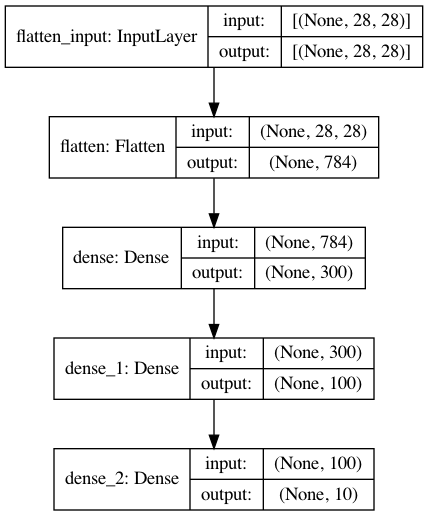

In [20]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [21]:
model.layers

In [22]:
hidden1 = model.layers[1]

In [23]:
hidden1.name

'dense'

In [24]:
model.get_layer('dense') is hidden1

True

In [25]:
weights, biases = hidden1.get_weights()

In [26]:
# 모델 만들고 나서 compile() 메서드 호출하여 손실 함수와 옵티마이저 지정
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

In [27]:
# 모델 훈련과 평가
history = model.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_valid, y_valid)) # 검증 세트는 선택사항


Epoch 1/30
1719/1719 [==============================] - 1s 616us/step - loss: 0.9919 - accuracy: 0.6915 - val_loss: 0.5673 - val_accuracy: 0.7926
Epoch 2/30
1719/1719 [==============================] - 1s 482us/step - loss: 0.5077 - accuracy: 0.8223 - val_loss: 0.4562 - val_accuracy: 0.8458
Epoch 3/30
1719/1719 [==============================] - 1s 469us/step - loss: 0.4465 - accuracy: 0.8433 - val_loss: 0.4292 - val_accuracy: 0.8508
Epoch 4/30
1719/1719 [==============================] - 1s 462us/step - loss: 0.4180 - accuracy: 0.8523 - val_loss: 0.3878 - val_accuracy: 0.8690
Epoch 5/30
1719/1719 [==============================] - 1s 464us/step - loss: 0.3942 - accuracy: 0.8612 - val_loss: 0.3981 - val_accuracy: 0.8618
Epoch 6/30
1719/1719 [==============================] - 1s 462us/step - loss: 0.3815 - accuracy: 0.8672 - val_loss: 0.3743 - val_accuracy: 0.8682
Epoch 7/30
1719/1719 [==============================] - 1s 476us/step - loss: 0.3701 - accuracy: 0.8687 - val_loss: 0.3764 -

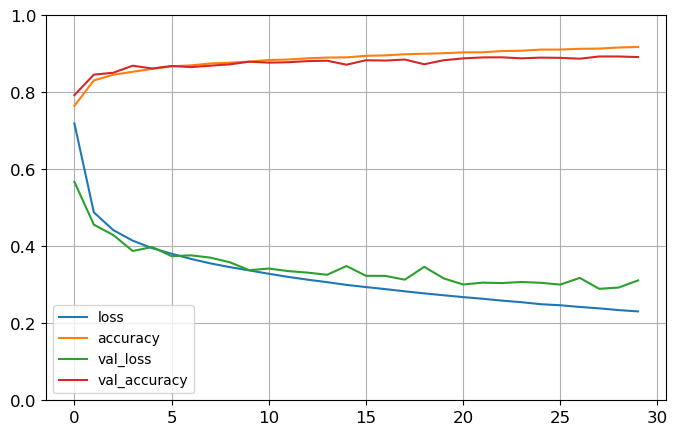

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
# 훈련 곡선을 볼 때 왼쪽으로 에포크의 절반만큼 이동해서 생각해야한다
# 검증 손실은 에포크가 끝난 후에 계산되고 훈련 소실은 에포크 진행되는 동안 계산되기 때문

In [29]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 290us/step - loss: 0.3527 - accuracy: 0.8731


[0.3526512086391449, 0.8730999827384949]

In [ ]:
# 모델을 사용해 예측 만들기
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)